<a href="https://colab.research.google.com/github/pcashman21/feral-cat-census/blob/main/analyze_keypoint_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook analyzes a YOLOv8 set of pose labels to understand the distribution of keypoints, links connecting keypoints, and possible ratios between links, in the labels.  This gives us an idea of how realistic it is to use pose data as a way to identify different images of the same cat.  Apart from the accuracy of the pose estimation model, just the presence or absence of keypoints limits the kind of comparisons we can do.

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

In [2]:
!unzip feral-cat-pose-detection-6.v4i.yolov8.zip

Archive:  feral-cat-pose-detection-6.v4i.yolov8.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
  inflating: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/group0002_jpeg_cat-4_png.rf.5405d08e974c586e35ed6661df314415.jpg  
 extracting: test/images/group0006_jpeg_cat-0_png.rf.a2664719e5fac6b27537d25990fbca75.jpg  
 extracting: test/images/group0006_jpeg_cat-9_png.rf.f68a1aac4e761557adbb921d92a0b81e.jpg  
 extracting: test/images/group0010_jpeg_cat-1_png.rf.39707877a9b1f4d548e0e9c1f4725ae4.jpg  
 extracting: test/images/group0017_jpeg_cat-2_png.rf.96056f3114ec4674f2f8c0a4c6c8b49d.jpg  
 extracting: test/images/group0059_jpeg_cat-1_png.rf.02701404279548e7995db202e7b77cee.jpg  
 extracting: test/images/group0067_cat-5_png.rf.f7f50b8af5d6a2b0223b118b8f0da62d.jpg  
 extracting: test/images/group0069_jpeg_cat-0_png.rf.9c101f4bdcd929846a220b6cb3c92368.jpg  
 extracting: test/images/group0092_jpeg_cat-3_png.rf.b2723

In [3]:
# YOLOv8 label data is stored in one text file corresponding to one image.
# Get all the text files for the training, validation, and testing of the model.
label_files = glob.glob('train/labels/*.txt')
label_files.extend(glob.glob('valid/labels/*.txt'))
label_files.extend(glob.glob('test/labels/*.txt'))
print(len(label_files))

1125


In [4]:
# Define the names of keypoints in the same order they are defined in Roboflow.  To determine this,
# export the dataset in COCO format (see this link, click Generate, and choose the COCO format:
# https://app.roboflow.com/feralcatposeestimation/feral-cat-pose-detection-6/4).  Within the JSON file
# _annotations.coco.json, find the "categories" entry, which is an array, and check the second item
# in the array, which is the list of names of keypoints in the order in which they are output to
# a lable file.
keypoints = ["left_earbase",
                "right_earbase",
                "left_eye",
                "right_eye",
                "nose",
                "mouth",
                "withers",
                "tailbase",
                "left_elbow",
                "left_wrist",
                "left_front_paw",
                "right_elbow",
                "right_wrist",
                "right_front_paw",
                "left_knee",
                "left_ankle",
                "left_rear_paw",
                "right_knee",
                "right_ankle",
                "right_rear_paw"]
columns = ['filename']
columns.extend(keypoints)

In [5]:
# A link is defined by two keypoints.  The following named links are the ones that
# seem to make sense.
links = {'earbases': ["left_earbase", "right_earbase"],
         'eyes': ["left_eye", "right_eye"],
         'nose_to_mouth': ["nose", "mouth"],
         'left_ear_to_eye': ["left_earbase", "left_eye"],
         'right_ear_to_eye': ["right_earbase", "right_eye"],
         'left_eye_to_nose': ["nose", "left_eye"],
         'right_eye_to_nose': ["nose", "right_eye"],
         'nose_to_mouth': ["nose", "mouth"],
         'withers_to_tailbase': ["withers", "tailbase"],
         'left_elbow_to_wrist': ["left_elbow", "left_wrist"],
         'right_elbow_to_wrist': ["right_elbow", "right_wrist"],
         'left_knee_to_ankle': ["left_knee", "left_ankle"],
         'right_knee_to_ankle': ["right_knee", "right_ankle"],
         'left_wrist_to_paw': ["left_wrist", "left_front_paw"],
         'right_wrist_to_paw': ["right_wrist", "right_front_paw"],
         'left_ankle_to_paw': ["left_ankle", "left_rear_paw"],
         'right_ankle_to_paw': ["right_ankle", "right_rear_paw"]}
link_keys = list(links.keys())
link_keys.insert(0, 'filename')

In [16]:
# A ratio really depends on two values being present.  It doesn't matter, for the
# purpose of existence, which is the denominator and which the numerator.
# The following named ratios are the ones that seem to make sense.
ratios = {'earbase_to_eyes': ["earbases", "eyes"],
          'earbase_to_nose_mouth': ["earbases", "nose_to_mouth"],
          'ears_to_eyes': ["left_ear_to_eye", "right_ear_to_eye"],
          'left_elbow_wrist_paw': ["left_elbow_to_wrist", "left_wrist_to_paw"],
          'right_elbow_wrist_paw': ["right_elbow_to_wrist", "right_wrist_to_paw"],
          'left_knee_ankle_paw': ["left_knee_to_ankle", "left_ankle_to_paw"],
          'right_knee_ankle_paw': ["right_knee_to_ankle", "right_ankle_to_paw"],}
ratio_keys = list(ratios.keys())
ratio_keys.insert(0, 'filename')

In [7]:
def parse_yolo_label_file(file_path):
  """
  Parse a single YOLOv8 label file.

  :param file_path: The path to the YOLOv8 label file.
  :return: None.
  :side-effects: The global variable df_keypoints is filled with the parsed data.
  """
  with open(file_path, 'r') as f:
        lines = f.readlines()
        if len(lines) == 0:
            return
        label_components = lines[0].strip().split(' ')
        next_keypoint_index = 0
        row_data = {'filename': os.path.basename(file_path)}
        # The first six components in the label file are:
        #   0: Index of the object class (0 for the one category -- cat)
        #.  1,2: x-center and y-center of the bounding box
        #.  3,4: width and height of bounding box
        #   5,6,7: x and y coordinates of keypoint 0, and keypoint visibility
        #   8, 9, 10: same for keypoint 1, and so on
        # Visibility: 0 => deleted kp, 1 => occluded kp, 2 => visible kp
        # All our kps should be either deleted or visible, none occluded.
        for i in range(7, len(label_components), 3):
          if int(label_components[i]) == 2: # keypoint is visible
            row_data[keypoints[next_keypoint_index]] = 1
          else:
            row_data[keypoints[next_keypoint_index]] = 0
          next_keypoint_index += 1
        df_keypoints.loc[len(df_keypoints)] = row_data


In [8]:
# Create a dataframe whose columns are the names of the keypoints, with "filename" coming first.
df_keypoints = pd.DataFrame(columns=columns)

In [9]:
# Process all the label files
for file_path in label_files:
    parse_yolo_label_file(file_path)

In [10]:
num_labels = len(df_keypoints) # Calc number of lines in df_keypoints before adding Total and Percent rows
df_keypoints.loc['Total'] = 0
df_keypoints.loc['Percent'] = 0
# Sum the number of visible keypoints in each column, where each column is a keypoint
for kp in keypoints:
  keypoint_total = df_keypoints[kp].sum()
  df_keypoints.at['Total', kp] = keypoint_total
  df_keypoints.at['Percent', kp] = keypoint_total / num_labels
print(df_keypoints.loc['Total'])
print(df_keypoints.loc['Percent'])

filename               0
left_earbase       582.0
right_earbase      603.0
left_eye           678.0
right_eye          677.0
nose               637.0
mouth              504.0
withers            339.0
tailbase           403.0
left_elbow         150.0
left_wrist         141.0
left_front_paw     427.0
right_elbow        151.0
right_wrist        118.0
right_front_paw    420.0
left_knee           99.0
left_ankle         106.0
left_rear_paw      199.0
right_knee         109.0
right_ankle        113.0
right_rear_paw     224.0
Name: Total, dtype: object
filename                  0
left_earbase       0.523852
right_earbase      0.542754
left_eye           0.610261
right_eye          0.609361
nose               0.573357
mouth              0.453645
withers            0.305131
tailbase           0.362736
left_elbow         0.135014
left_wrist         0.126913
left_front_paw     0.384338
right_elbow        0.135914
right_wrist        0.106211
right_front_paw    0.378038
left_knee          0.089109


<ipython-input-10-71400d62c9e1>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5238523852385238' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_keypoints.at['Percent', kp] = keypoint_total / num_labels
<ipython-input-10-71400d62c9e1>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5427542754275427' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_keypoints.at['Percent', kp] = keypoint_total / num_labels
<ipython-input-10-71400d62c9e1>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6102610261026102' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_keypoints.at['Percent', kp] = keypoint_total / num_labels
<ipython-input-10-71400d62c9e1>

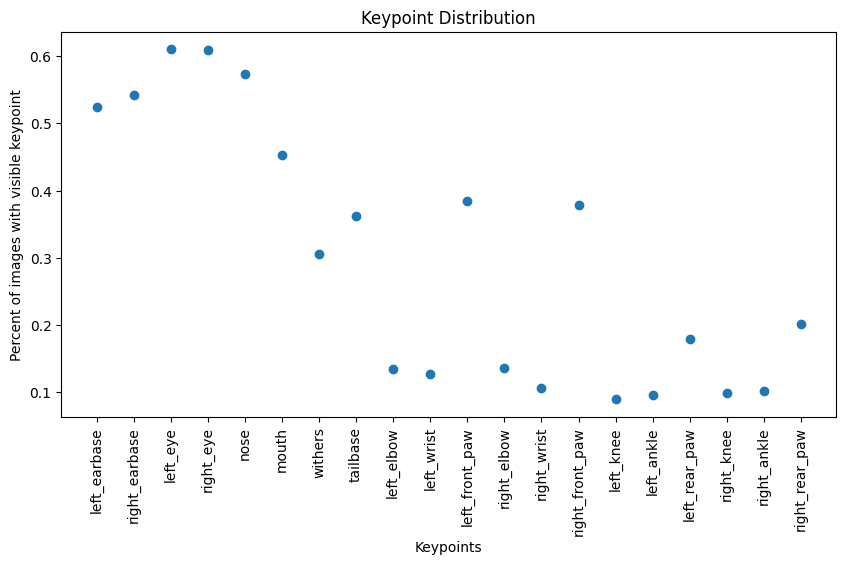

In [11]:
# Create a scatter plot of the keypoint percentages
x = keypoints
y = df_keypoints.drop(columns=['filename']).loc['Percent'].values

plt.figure(figsize=(10, 5))
plt.scatter(x, y)
plt.xticks(rotation=90)
plt.xlabel('Keypoints')
plt.ylabel('Percent of images with visible keypoint')
plt.title('Keypoint Distribution')
plt.show()

In [12]:
def compute_links(df_keypoints, link_keys):
  """
  Compute the presence or absence of links between keypoints.

  :param df_keypoints: Dataframe with the keypoint visibility information in each column
  :param link_keys: List of names of links to compute
  :return: Dataframe with the presence or absence of the links
  """
  # Create a dataframe whose columns are the names of the links, with "filename" coming first.
  df = pd.DataFrame(columns=link_keys)
  df['filename'] = df_keypoints['filename']
  for link in link_keys[1:]:
    col_for_point_A = links[link][0] # Get name of keypoint which is one end of the link
    col_for_point_B = links[link][1] # Get the name of the other keypoint
    # Add the keypoint visibilities together
    df[link] = df_keypoints[col_for_point_A] + df_keypoints[col_for_point_B]
    # If the value is >= 2, the link is present
    df[link] = df[link].apply(lambda x: 1 if x >= 2 else 0)
  return df

df_links = compute_links(df_keypoints, link_keys)
df_links.head(10)


,filename,earbases,eyes,nose_to_mouth,left_ear_to_eye,right_ear_to_eye,left_eye_to_nose,right_eye_to_nose,withers_to_tailbase,left_elbow_to_wrist,right_elbow_to_wrist,left_knee_to_ankle,right_knee_to_ankle,left_wrist_to_paw,right_wrist_to_paw,left_ankle_to_paw,right_ankle_to_paw
0,group0625_jpeg_cat-0_png.rf.4a82fc5506469e9b50...,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1
1,group0740_cat-0_png.rf.7344c9e17ab319e2d9ad3c0...,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0
2,group0893_cat-0_png.rf.58c4a601cf74a61f2234d62...,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0
3,group0713_jpeg_cat-1_png.rf.516f63711234bfadf8...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,group0360_cat-0_png.rf.ef96e784c42e89d3b2a64b9...,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0
5,group1085_cat-0_png.rf.1a93daf1079f809839f478c...,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1
6,group0809_jpeg_cat-10_png.rf.8b145efc1ccdc3562...,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0
7,group0612_jpeg_cat-0_png.rf.96356cc67b76ff18e4...,1,1,1,1,1,1,1,0,0,1,0,1,1,1,0,1
8,group1052_jpeg_cat-0_png.rf.f149202fb6e5c2b0b8...,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0
9,group0808_png_cat-1_png.rf.f44d043e30befab092b...,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0


In [13]:
# Compute the percentage of each link's presence in the dataset
num_labels = len(df_links)-2 # Calc number of lines in df_links before adding Total and Percent rows
df_keypoints.loc['Total'] = 0
df_keypoints.loc['Percent'] = 0
for link in links:
  link_total = df_links[link].sum()
  df_links.at['Total', link] = link_total
  df_links.at['Percent', link] = link_total / num_labels
print(df_links.loc['Total'])
print(df_links.loc['Percent'])

filename                    0
earbases                565.0
eyes                    678.0
nose_to_mouth           504.0
left_ear_to_eye         583.0
right_ear_to_eye        602.0
left_eye_to_nose        638.0
right_eye_to_nose       637.0
withers_to_tailbase     210.0
left_elbow_to_wrist      82.0
right_elbow_to_wrist     73.0
left_knee_to_ankle       70.0
right_knee_to_ankle      79.0
left_wrist_to_paw       138.0
right_wrist_to_paw      115.0
left_ankle_to_paw        90.0
right_ankle_to_paw       96.0
Name: Total, dtype: object
filename                       0
earbases                0.508551
eyes                    0.610261
nose_to_mouth           0.453645
left_ear_to_eye         0.524752
right_ear_to_eye        0.541854
left_eye_to_nose        0.574257
right_eye_to_nose       0.573357
withers_to_tailbase     0.189019
left_elbow_to_wrist     0.073807
right_elbow_to_wrist    0.065707
left_knee_to_ankle      0.063006
right_knee_to_ankle     0.071107
left_wrist_to_paw       0.124212
r

<ipython-input-13-bb1ea29905bc>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5085508550855086' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_links.at['Percent', link] = link_total / num_labels
<ipython-input-13-bb1ea29905bc>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6102610261026102' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_links.at['Percent', link] = link_total / num_labels
<ipython-input-13-bb1ea29905bc>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.45364536453645365' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_links.at['Percent', link] = link_total / num_labels
<ipython-input-13-bb1ea29905bc>:8: FutureWarning

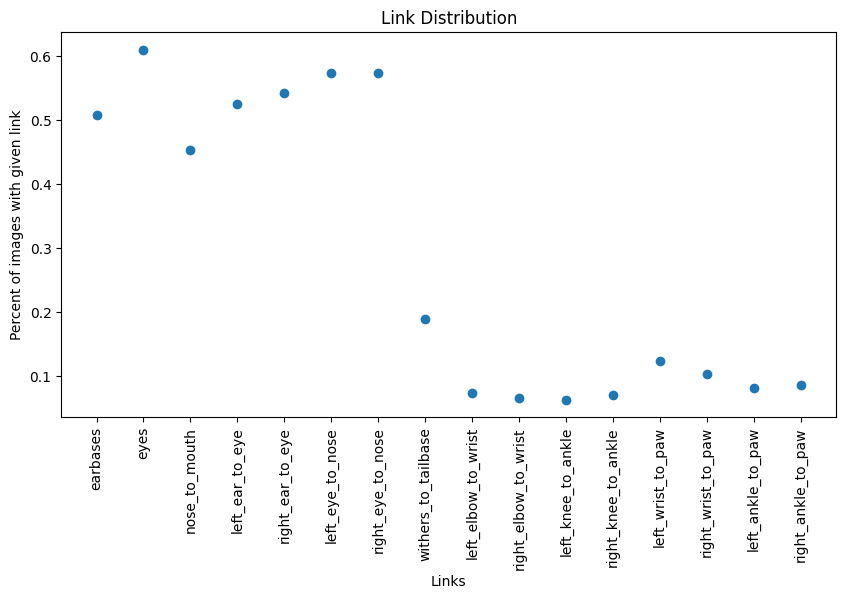

In [14]:
# Create a scatter plot of the link percentages
x = link_keys[1:]
y = df_links.drop(columns=['filename']).loc['Percent'].values

plt.figure(figsize=(10, 5))
plt.scatter(x, y)
plt.xticks(rotation=90)
plt.xlabel('Links')
plt.ylabel('Percent of images with given link')
plt.title('Link Distribution')
plt.show()

In [17]:
def compute_ratios(df_links, ratio_keys):
  """
  Compute the presence or absence of ratios between links.

  :param df_links: Dataframe with the link visibility information in each column
  :param ratio_keys: List of names of ratios to compute
  :return: Dataframe with the presence or absence of the ratios
  """
  # Create a dataframe whose columns are the names of the ratios, with "filename" coming first.
  df = pd.DataFrame(columns=ratio_keys)
  df['filename'] = df_links['filename']
  for ratio in ratio_keys[1:]:
    col_for_link_A = ratios[ratio][0] # Get name of link which is one element of the ratio
    col_for_link_B = ratios[ratio][1] # Get the name of the other link
    # Add the link visibilities together
    df[ratio] = df_links[col_for_link_A] + df_links[col_for_link_B]
    # If the value is >= 2, the link is present
    df[ratio] = df[ratio].apply(lambda x: 1 if x >= 2 else 0)
  return df

df_ratios = compute_ratios(df_links, ratio_keys)
df_ratios.head(10)

,filename,earbase_to_eyes,earbase_to_nose_mouth,ears_to_eyes,left_elbow_wrist_paw,right_elbow_wrist_paw,left_knee_ankle_paw,right_knee_ankle_paw
0,group0625_jpeg_cat-0_png.rf.4a82fc5506469e9b50...,0,0,0,0,1,0,1
1,group0740_cat-0_png.rf.7344c9e17ab319e2d9ad3c0...,1,1,1,0,0,0,0
2,group0893_cat-0_png.rf.58c4a601cf74a61f2234d62...,0,0,0,0,0,0,0
3,group0713_jpeg_cat-1_png.rf.516f63711234bfadf8...,0,0,0,0,0,0,0
4,group0360_cat-0_png.rf.ef96e784c42e89d3b2a64b9...,1,1,1,0,0,0,0
5,group1085_cat-0_png.rf.1a93daf1079f809839f478c...,1,1,1,0,0,0,0
6,group0809_jpeg_cat-10_png.rf.8b145efc1ccdc3562...,1,1,1,0,0,0,0
7,group0612_jpeg_cat-0_png.rf.96356cc67b76ff18e4...,1,1,1,0,1,0,1
8,group1052_jpeg_cat-0_png.rf.f149202fb6e5c2b0b8...,1,1,1,0,0,0,0
9,group0808_png_cat-1_png.rf.f44d043e30befab092b...,1,1,1,0,0,0,0


In [18]:
# Compute the percentage of each ratios's presence in the dataset
num_labels = len(df_ratios)-2 # Calc number of lines in df_ratios before adding Total and Percent rows
df_ratios.loc['Total'] = 0
df_ratios.loc['Percent'] = 0
for ratio in ratios:
  ratio_total = df_ratios[ratio].sum()
  df_ratios.at['Total', ratio] = ratio_total
  df_ratios.at['Percent', ratio] = ratio_total / num_labels
print(df_ratios.loc['Total'])
print(df_ratios.loc['Percent'])

filename                     0
earbase_to_eyes          563.0
earbase_to_nose_mouth    456.0
ears_to_eyes             563.0
left_elbow_wrist_paw      80.0
right_elbow_wrist_paw     69.0
left_knee_ankle_paw       63.0
right_knee_ankle_paw      66.0
Name: Total, dtype: object
filename                        0
earbase_to_eyes          0.506751
earbase_to_nose_mouth    0.410441
ears_to_eyes             0.506751
left_elbow_wrist_paw     0.072007
right_elbow_wrist_paw    0.062106
left_knee_ankle_paw      0.056706
right_knee_ankle_paw     0.059406
Name: Percent, dtype: object


<ipython-input-18-6c40fcee4658>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5067506750675067' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_ratios.at['Percent', ratio] = ratio_total / num_labels
<ipython-input-18-6c40fcee4658>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.41044104410441046' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_ratios.at['Percent', ratio] = ratio_total / num_labels
<ipython-input-18-6c40fcee4658>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.07200720072007201' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_ratios.at['Percent', ratio] = ratio_total / num_labels
<ipython-input-18-6c40fcee4658>:8: Fut

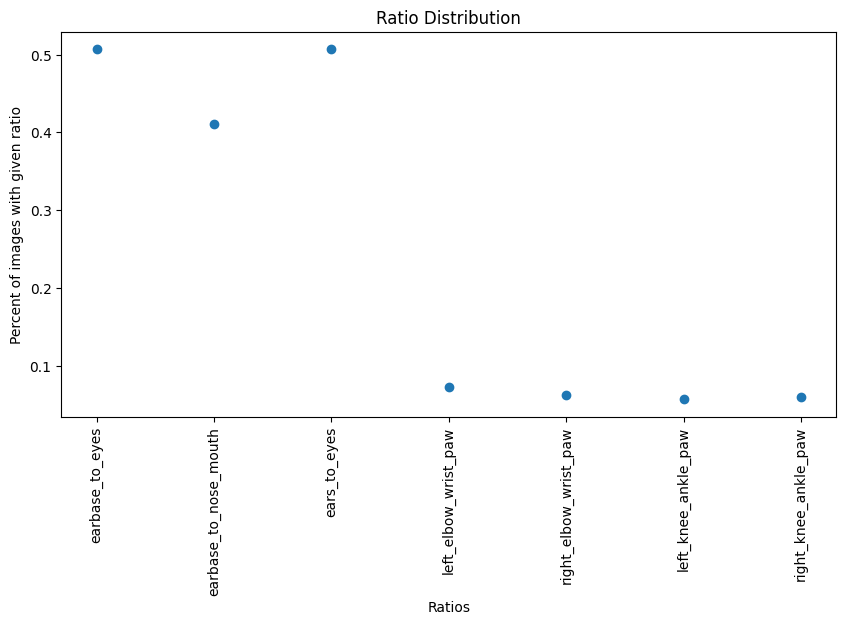

In [19]:
# Create a scatter plot of the ratio percentages
x = ratio_keys[1:]
y = df_ratios.drop(columns=['filename']).loc['Percent'].values

plt.figure(figsize=(10, 5))
plt.scatter(x, y)
plt.xticks(rotation=90)
plt.xlabel('Ratios')
plt.ylabel('Percent of images with given ratio')
plt.title('Ratio Distribution')
plt.show()